In [54]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import time
import math
from torch.utils import data
from tqdm.notebook import tqdm
import warnings
from train import train_epoch, eval_epoch, Dataset, blur_input

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3,4,5,6,7"
basis = torch.load("kernel_basis.pt")
train_direc = "/global/cscratch1/sd/roseyu/Eliza/TF-net/Data/data_64/sample_"
img_direc = "/global/cscratch1/sd/roseyu/Eliza/Img"

## Scale

In [55]:
class scale_conv2d(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, l = 3, sout = 5, activation = True):
        super(scale_conv2d, self).__init__()
        self.output_channels= output_channels
        self.input_channels = input_channels
        self.l = l
        self.sout = sout
        self.activation = activation
        self.kernel_size = kernel_size
        self.bias = nn.Parameter(torch.Tensor(output_channels))
        weight_shape = (output_channels, l, 2, input_channels//2, kernel_size, kernel_size)
        self.stdv = math.sqrt(1. / (kernel_size * kernel_size * input_channels * l))
        self.weights = nn.Parameter(torch.Tensor(*weight_shape))
        self.reset_parameters()
        self.batchnorm = nn.BatchNorm3d(sout)# affine=False
        
    def reset_parameters(self):
        self.weights.data.uniform_(-self.stdv, self.stdv)
        if self.bias is not None:
            self.bias.data.fill_(0)
            
    def shrink_kernel(self, kernel, up_scale):
        up_scale = torch.tensor(up_scale).float()
        pad_in = (torch.ceil(up_scale**2).int())*((kernel.shape[2]-1)//2)
        pad_h = (torch.ceil(up_scale).int())*((kernel.shape[3]-1)//2)
        pad_w = (torch.ceil(up_scale).int())*((kernel.shape[4]-1)//2)
        padded_kernel = F.pad(kernel, (pad_w, pad_w, pad_h, pad_h, pad_in, pad_in))
        delta = up_scale%1
        if delta == 0:
            shrink_factor = 1
        else:
            # shrink_factor for coordinates if the kernel is over shrunk.
            shrink_factor = (((kernel.shape[4]-1))/(padded_kernel.shape[-1]-1)*(up_scale+1))
            # Adjustment to deal with weird filtering on the grid sample function.
            shrink_factor = 1.5*(shrink_factor-0.5)**3 + 0.57   

        grid = torch.meshgrid(torch.linspace(-1, 1, kernel.shape[2])*(shrink_factor**2),
                              torch.linspace(-1, 1, kernel.shape[3])*shrink_factor, 
                              torch.linspace(-1, 1, kernel.shape[4])*shrink_factor)

        grid = torch.cat([grid[2].unsqueeze(0).unsqueeze(-1), 
                          grid[1].unsqueeze(0).unsqueeze(-1), 
                          grid[0].unsqueeze(0).unsqueeze(-1)], dim = -1).repeat(kernel.shape[0],1,1,1,1)

        new_kernel = F.grid_sample(padded_kernel, grid.to(device))
        if kernel.shape[-1] - 2*up_scale > 0:
            new_kernel = new_kernel * (kernel.shape[-1]**2/((kernel.shape[-1] - 2*up_scale)**2 + 0.01))
        return new_kernel
    
    def dilate_kernel(self, kernel, dilation):
        if dilation == 0:
            return kernel 

        dilation = torch.tensor(dilation).float()
        delta = dilation%1

        d_in = torch.ceil(dilation**2).int()
        new_in = kernel.shape[2] + (kernel.shape[2]-1)*d_in

        d_h = torch.ceil(dilation).int()
        new_h = kernel.shape[3] + (kernel.shape[3]-1)*d_h

        d_w = torch.ceil(dilation).int()
        new_w = kernel.shape[4] + (kernel.shape[4]-1)*d_h

        new_kernel = torch.zeros(kernel.shape[0], kernel.shape[1], new_in, new_h, new_w)
        new_kernel[:,:,::(d_in+1),::(d_h+1), ::(d_w+1)] = kernel
        shrink_factor = 1
        # shrink coordinates if the kernel is over dilated.
        if delta != 0:
            new_kernel = F.pad(new_kernel, ((kernel.shape[4]-1)//2, (kernel.shape[4]-1)//2)*3)

            shrink_factor = (new_kernel.shape[-1] - 1 - (kernel.shape[4]-1)*(delta))/(new_kernel.shape[-1] - 1) 
            grid = torch.meshgrid(torch.linspace(-1, 1, new_in)*(shrink_factor**2), 
                                  torch.linspace(-1, 1, new_h)*shrink_factor, 
                                  torch.linspace(-1, 1, new_w)*shrink_factor)

            grid = torch.cat([grid[2].unsqueeze(0).unsqueeze(-1), 
                              grid[1].unsqueeze(0).unsqueeze(-1), 
                              grid[0].unsqueeze(0).unsqueeze(-1)], dim = -1).repeat(kernel.shape[0],1,1,1,1)

            new_kernel = F.grid_sample(new_kernel, grid)         
            #new_kernel = new_kernel/new_kernel.sum()*kernel.sum()
        return new_kernel[:,:,-kernel.shape[2]:]
    
    
    def forward(self, xx):
        #print(self.weights.shape, xx.shape)
        out = []
        for s in range(self.sout):
            t = np.minimum(s + self.l, self.sout)
            inp = xx[:,s:t].reshape(xx.shape[0], -1, xx.shape[-2], xx.shape[-1])
            w = self.weights[:,:(t-s),:,:,:].reshape(self.output_channels, 2*(t-s), self.input_channels//2, self.kernel_size, self.kernel_size).to(device)
            
            if (s - self.sout//2) < 0:
                new_kernel = self.shrink_kernel(w, (self.sout//2 - s)/2).to(device)
            elif (s - self.sout//2) > 0:
                new_kernel = self.dilate_kernel(w, (s - self.sout//2)/2).to(device)
            else:
                new_kernel = w.to(device)
    
            new_kernel = new_kernel.reshape(self.output_channels, (t-s)*self.input_channels, new_kernel.shape[-2], new_kernel.shape[-1])
            conv = F.conv2d(inp, new_kernel, padding = ((new_kernel.shape[-2]-1)//2, (new_kernel.shape[-1]-1)//2))# bias = self.bias,
                 
            out.append(conv.unsqueeze(1))

        out = torch.cat(out, dim = 1) 
        
        # Activation Function
        if self.activation: 
            #out = self.batchnorm(out)
            out = F.leaky_relu(out)
        
        return out 
    
class scale_cnn(nn.Module):
    def __init__(self, input_channels, output_channels, hidden_dim, num_layers, kernel_size, activation = False):
        super(scale_cnn, self).__init__()
        layers = [scale_conv2d(input_channels, hidden_dim, kernel_size, activation=activation)] + \
                 [scale_conv2d(hidden_dim, hidden_dim, kernel_size, activation=activation) for i in range(num_layers - 2)] + \
                 [scale_conv2d(hidden_dim, 2, kernel_size, sout = 1, activation=False)]
        self.layers = nn.Sequential(*layers)

    def forward(self, xx):
        return self.layers(xx).squeeze(1)

# Rot (+ UM + Scale)
- [x] test for equivariance: check Scale, Rot, UM
- [x] train on untransformed, test on Scale + Rot + UM
- [x] train on random Scale + Rot + UM, test on Scale + Rot + UM (same dataset)

In [56]:
class scale_conv2d(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, l=3, sout=5, um_dim=2, activation=True):
        super(scale_conv2d, self).__init__()
        self.output_channels= output_channels
        self.input_channels = input_channels
        self.l = l
        self.sout = sout
        self.activation = activation
        self.kernel_size = kernel_size
        self.um_dim = um_dim
        self.pad_size = (kernel_size - 1)//2
        self.bias = nn.Parameter(torch.Tensor(output_channels))
        weight_shape = (output_channels, l, 2, input_channels//2, kernel_size, kernel_size)
        self.stdv = math.sqrt(1. / (kernel_size * kernel_size * input_channels * l))
        self.weights = nn.Parameter(torch.Tensor(*weight_shape))
        self.reset_parameters()
        self.batchnorm = nn.BatchNorm3d(sout)# affine=False
        
    def reset_parameters(self):
        self.weights.data.uniform_(-self.stdv, self.stdv)
        if self.bias is not None:
            self.bias.data.fill_(0)
            
    def shrink_kernel(self, kernel, up_scale):
        up_scale = torch.tensor(up_scale).float()
        pad_in = (torch.ceil(up_scale**2).int())*((kernel.shape[2]-1)//2)
        pad_h = (torch.ceil(up_scale).int())*((kernel.shape[3]-1)//2)
        pad_w = (torch.ceil(up_scale).int())*((kernel.shape[4]-1)//2)
        padded_kernel = F.pad(kernel, (pad_w, pad_w, pad_h, pad_h, pad_in, pad_in))
        delta = up_scale%1
        if delta == 0:
            shrink_factor = 1
        else:
            # shrink_factor for coordinates if the kernel is over shrunk.
            shrink_factor = (((kernel.shape[4]-1))/(padded_kernel.shape[-1]-1)*(up_scale+1))
            # Adjustment to deal with weird filtering on the grid sample function.
            shrink_factor = 1.5*(shrink_factor-0.5)**3 + 0.57   

        grid = torch.meshgrid(torch.linspace(-1, 1, kernel.shape[2])*(shrink_factor**2),
                              torch.linspace(-1, 1, kernel.shape[3])*shrink_factor, 
                              torch.linspace(-1, 1, kernel.shape[4])*shrink_factor)

        grid = torch.cat([grid[2].unsqueeze(0).unsqueeze(-1), 
                          grid[1].unsqueeze(0).unsqueeze(-1), 
                          grid[0].unsqueeze(0).unsqueeze(-1)], dim = -1).repeat(kernel.shape[0],1,1,1,1)

        new_kernel = F.grid_sample(padded_kernel, grid.to(device))
        if kernel.shape[-1] - 2*up_scale > 0:
            new_kernel = new_kernel * (kernel.shape[-1]**2/((kernel.shape[-1] - 2*up_scale)**2 + 0.01))
        return new_kernel
    
    def dilate_kernel(self, kernel, dilation):
        if dilation == 0:
            return kernel 

        dilation = torch.tensor(dilation).float()
        delta = dilation%1

        d_in = torch.ceil(dilation**2).int()
        new_in = kernel.shape[2] + (kernel.shape[2]-1)*d_in

        d_h = torch.ceil(dilation).int()
        new_h = kernel.shape[3] + (kernel.shape[3]-1)*d_h

        d_w = torch.ceil(dilation).int()
        new_w = kernel.shape[4] + (kernel.shape[4]-1)*d_h

        new_kernel = torch.zeros(kernel.shape[0], kernel.shape[1], new_in, new_h, new_w)
        new_kernel[:,:,::(d_in+1),::(d_h+1), ::(d_w+1)] = kernel
        shrink_factor = 1
        # shrink coordinates if the kernel is over dilated.
        if delta != 0:
            new_kernel = F.pad(new_kernel, ((kernel.shape[4]-1)//2, (kernel.shape[4]-1)//2)*3)

            shrink_factor = (new_kernel.shape[-1] - 1 - (kernel.shape[4]-1)*(delta))/(new_kernel.shape[-1] - 1) 
            grid = torch.meshgrid(torch.linspace(-1, 1, new_in)*(shrink_factor**2), 
                                  torch.linspace(-1, 1, new_h)*shrink_factor, 
                                  torch.linspace(-1, 1, new_w)*shrink_factor)

            grid = torch.cat([grid[2].unsqueeze(0).unsqueeze(-1), 
                              grid[1].unsqueeze(0).unsqueeze(-1), 
                              grid[0].unsqueeze(0).unsqueeze(-1)], dim = -1).repeat(kernel.shape[0],1,1,1,1)

            new_kernel = F.grid_sample(new_kernel, grid)         
            #new_kernel = new_kernel/new_kernel.sum()*kernel.sum()
        return new_kernel[:,:,-kernel.shape[2]:]
    
    def unfold(self, xx):
        xx = xx.reshape(xx.shape[0] * xx.shape[1], -1, xx.shape[-2], xx.shape[-1])
        out = F.pad(xx, ((self.pad_size, self.pad_size) * 2), mode='replicate')
        out = F.unfold(out, kernel_size=self.kernel_size)
        out = out.reshape(out.shape[0], self.input_channels, self.kernel_size, self.kernel_size, out.shape[-1])
        out = out.reshape(out.shape[0], self.input_channels, self.kernel_size, self.kernel_size, xx.shape[-2],
                          xx.shape[-1])
        return out
    
    def subtract_mean(self, xx):
        out = xx.reshape(xx.shape[0], self.input_channels // self.um_dim, self.um_dim, self.kernel_size,
                         self.kernel_size, xx.shape[-2], xx.shape[-1])
        avgs = out.mean((1, 3, 4), keepdim=True)
        out -= avgs
        out = out.reshape(out.shape[0], self.input_channels, self.kernel_size, self.kernel_size, xx.shape[-2],
                          xx.shape[-1]).transpose(2, 4).transpose(-1, -2)
        out = out.reshape(out.shape[0], self.input_channels, xx.shape[-2] * self.kernel_size, xx.shape[-1],
                          self.kernel_size)
        out = out.reshape(out.shape[0], self.input_channels, xx.shape[-2] * self.kernel_size,
                          xx.shape[-1] * self.kernel_size)
        return out, avgs.squeeze(3).squeeze(3)
    
    
    def add_mean(self, out, avgs):
        out = out.reshape(out.shape[0], out.shape[1] // self.um_dim, self.um_dim, out.shape[-2], out.shape[-1])
        out += avgs
        out = out.reshape(out.shape[0], -1, out.shape[-2], out.shape[-1])
        return out
    
    def forward(self, xx): 
        xx_out = self.unfold(xx)
        xx_out, avgs = self.subtract_mean(xx_out)
        xx_out = xx_out.reshape(xx.shape[0], xx.shape[1], -1, xx_out.shape[-2], xx_out.shape[-1])

        out = []
        for s in range(self.sout):
            t = np.minimum(s + self.l, self.sout)
            inp = xx[:,s:t].reshape(xx.shape[0], -1, xx.shape[-2], xx.shape[-1])
            w = self.weights[:,:(t-s),:,:,:].reshape(self.output_channels, 2*(t-s), self.input_channels//2, self.kernel_size, self.kernel_size).to(device)
            
            if (s - self.sout//2) < 0:
                new_kernel = self.shrink_kernel(w, (self.sout//2 - s)/2).to(device)
            elif (s - self.sout//2) > 0:
                new_kernel = self.dilate_kernel(w, (s - self.sout//2)/2).to(device)
            else:
                new_kernel = w.to(device)
    
            new_kernel = new_kernel.reshape(self.output_channels, (t-s)*self.input_channels, new_kernel.shape[-2], new_kernel.shape[-1])
            conv = F.conv2d(inp, new_kernel, padding = ((new_kernel.shape[-2]-1)//2, (new_kernel.shape[-1]-1)//2))# bias = self.bias,
                 
            out.append(conv.unsqueeze(1))

        out = torch.cat(out, dim = 1) 
        
        # Activation Function
        if self.activation: 
            #out = self.batchnorm(out)
            out = F.leaky_relu(out)
        
        return out 
    
class rot_um_scale_cnn(nn.Module):
    def __init__(self, input_channels, output_channels, hidden_dim, num_layers, kernel_size, activation = False):
        super(rot_um_scale_cnn, self).__init__()
        layers = [scale_conv2d(input_channels, hidden_dim, kernel_size, activation=activation)] + \
                 [scale_conv2d(hidden_dim, hidden_dim, kernel_size, activation=activation) for i in range(num_layers - 2)] + \
                 [scale_conv2d(hidden_dim, 2, kernel_size, sout = 1, activation=False)]
        self.layers = nn.Sequential(*layers)

    def forward(self, xx):
        return self.layers(xx).squeeze(1)

In [57]:
name = "ResNet_1"
min_mse = 0.8
kernel_size = 3
hidden_dim = 128
num_layers = 2
learning_rate = 0.0001
input_length = 7
output_length = 1
batch_size = 1

train_indices = list(range(0, 10))
valid_indices = list(range(10, 15))

train_set = Dataset(train_indices, input_length, 40, output_length, train_direc)
valid_set = Dataset(valid_indices, input_length, 40, 6, train_direc)
train_loader = data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 8)
valid_loader = data.DataLoader(valid_set, batch_size = batch_size, shuffle = False, num_workers = 8)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
print("Initializing...")
model = rot_um_scale_cnn(activation = "leakyrelu", input_channels = input_length*2, hidden_dim = hidden_dim, num_layers = num_layers, 
                  output_channels = output_length, kernel_size = kernel_size).to(device)#
print("Done")

optimizer = torch.optim.Adam(model.parameters(), learning_rate,betas=(0.9, 0.999), weight_decay=4e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma=0.9)
loss_fun = torch.nn.MSELoss()


train_mse = []
valid_mse = []
test_mse = []

for i in range(5):
    start = time.time()
    scheduler.step()

    model.train()
    train_mse.append(train_epoch(train_loader, model, optimizer, loss_fun))
    model.eval()
    mse, preds, trues = eval_epoch(valid_loader, model, loss_fun)
    valid_mse.append(mse)

    if train_mse[-1] < min_mse:
        min_mse = train_mse[-1] 
        cnn_preds = preds
        cnn_trues = trues
        
        #torch.save(model, "model.pth")
    end = time.time()
    print(train_mse[-1], round((end-start)/60,5))#, valid_mse[-1]

Initializing...
Done
0.88758 0.25925
0.66308 0.25835
0.50735 0.25595


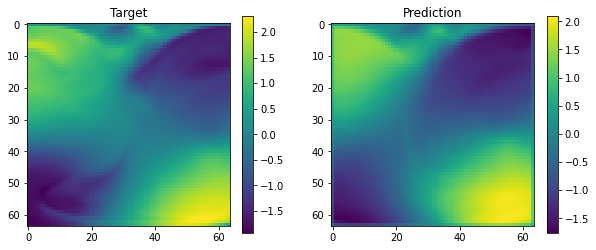

In [6]:
idx = 0
direc = 0
step = 0
fig=plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(cnn_trues[idx,step,direc])
plt.title("Target")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(cnn_preds[idx,step,direc])
plt.title("Prediction")
plt.colorbar()
plt.show()
fig.savefig(img_direc + '/rot_um_scale_target_pred', bbox_inches='tight')

In [ ]:
# # Rot
# fig=plt.figure(figsize=(10, 4))
# initial_kernel = model.layers[0].initial_kernel.cpu().data.numpy()
# trained_kernel = torch.einsum("abcd, cdefgh -> abefgh",  (model.layers[0].params, model.layers[0].basis.to(device))).cpu().data.numpy()

# plt.subplot(1, 2, 1)
# plt.hist(initial_kernel[:,0,:,:,0,0].flatten(), bins = 30)
# plt.subplot(1, 2, 2)
# plt.hist(trained_kernel[:,0,:,:,0,0].flatten(), bins = 30)
# #plt.xlim(-0.5, 0.5)
# plt.show()

## Rotationaly symmetric test

In [7]:
import torchvision.transforms.functional as TF
from torchvision import transforms
PIL = transforms.ToPILImage()
TTen = transforms.ToTensor()
from PIL import Image


def normalize(tensor):
    return (tensor - torch.min(tensor))/(torch.max(tensor) - torch.min(tensor))

def rotate(img, degree):
    #img shape 2*128*128
    #2*2 2*1*128*128 -> 2*1*128*128
    theta = torch.tensor(degree/180*np.pi)
    rot_m = torch.tensor([[torch.cos(theta), -torch.sin(theta)], [torch.sin(theta), torch.cos(theta)]])
    img = torch.einsum("ab, bcde -> acde",(rot_m, img.unsqueeze(1))).squeeze(1)
    mmin = torch.min(img)
    mmax = torch.max(img)
    img = normalize(img).data.numpy()
    x = TTen(TF.rotate(Image.fromarray(np.uint8(img[0]*255)),degree, expand =  True))
    y = TTen(TF.rotate(Image.fromarray(np.uint8(img[1]*255)),degree, expand =  True))
    rot_img = torch.cat([x, y], dim = 0)
    rot_img[rot_img!=0] = normalize(rot_img[rot_img!=0])
    rot_img[rot_img!=0] = rot_img[rot_img!=0]*(mmax - mmin) + mmin
    return rot_img

train_direc = "/global/cscratch1/sd/roseyu/Eliza/TF-net/Data/data_128/sample_"
input_length = 2
output_length = 3
batch_size = 4
train_indices = list(range(0, 2))

train_set = Dataset(train_indices, input_length, 40, output_length, train_direc)
train_loader = data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
for xx, yy in train_loader:
    break

In [8]:
torch.manual_seed(10)
degree = 90

print("Initializing...")
model = scale_cnn(activation="leakyrelu", input_channels=input_length*2, hidden_dim=hidden_dim, num_layers=num_layers, 
                  output_channels=output_length, kernel_size=kernel_size).to(device)#
print("Done")

xx = xx.reshape(-1, 4, 128, 128)
rot_xx = torch.cat([rotate(xx[0,:2], degree).unsqueeze(0), rotate(xx[0,-2:], degree).unsqueeze(0)] , dim = 1)#rotate(xx[0,0], degree).unsqueeze(0)

blur_rot_xx = blur_input(rot_xx.reshape(-1, 2, 2, 64, 64))
rot_xx_out = model(blur_rot_xx.to(device))
              
xx_out_rot = rotate((rot_xx_out[0]).cpu(), -degree)

Initializing...
Done


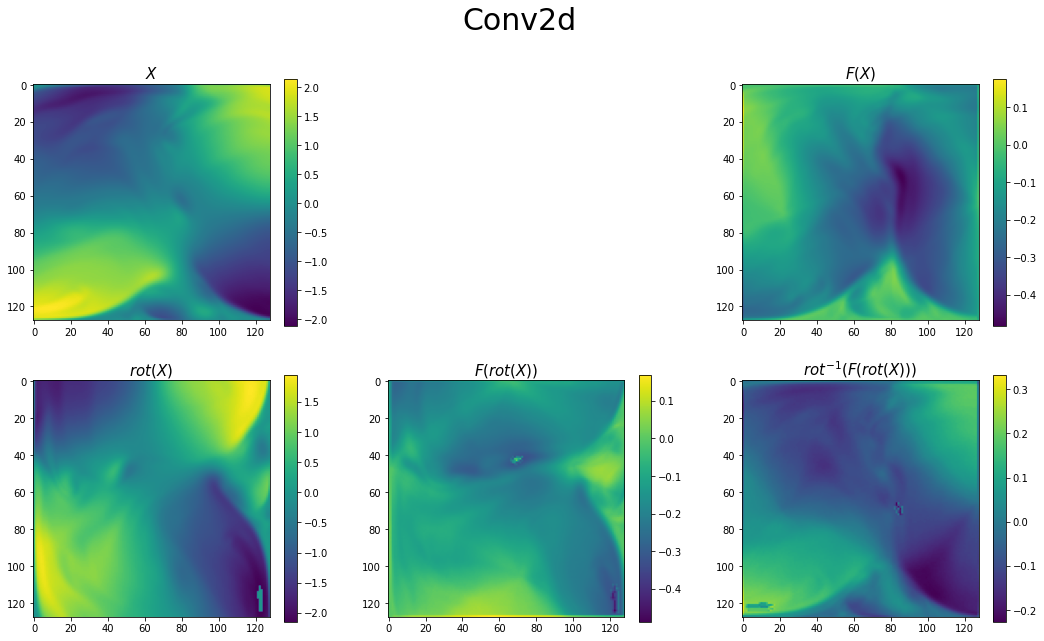

In [9]:
blur_xx = blur_input(xx.reshape(-1, 2, 2, 128, 128))
xx_out = model(blur_xx.to(device))

xx = xx.reshape(-1, 4, 128, 128)
rot_xx = torch.cat([rotate(xx[0,:2], degree).unsqueeze(0), rotate(xx[0,-2:], degree).unsqueeze(0)] , dim = 1)#rotate(xx[0,0], degree).unsqueeze(0)

blur_rot_xx = blur_input(rot_xx.reshape(-1, 2, 2, 128, 128))
rot_xx_out = model(blur_rot_xx.to(device))
                
xx_out_rot = rotate((rot_xx_out[0]).cpu(), -degree)

direc = 0
fig=plt.figure(figsize=(18, 10))
plt.subplot(2, 3, 1)
plt.imshow(xx[0,direc].cpu().data.numpy())
plt.title(r"$X$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 3)
plt.imshow(xx_out[0,direc].cpu().data.numpy())
plt.title(r"$F(X)$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 4)
plt.imshow(rot_xx[0, direc].cpu().data.numpy())
plt.title(r"$rot(X)$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 5)
plt.imshow(rot_xx_out[0,direc].cpu().data.numpy())
plt.title(r"$F(rot(X))$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 6)
plt.imshow(xx_out_rot[direc].cpu().data.numpy())
plt.title(r"$rot^{-1}(F(rot(X)))$", size = 15)
plt.colorbar()

plt.suptitle("Conv2d", size = 30)

plt.show()
fig.savefig(img_direc + '/rot_um_scale_conv2d_rot', bbox_inches='tight')

In [10]:
def rmse(y, y_hat):
    """Compute root mean squared error"""
    return torch.sqrt(torch.mean((y - y_hat).pow(2)))

def mse(y, y_hat):
    """Compute mean squared error"""
    return torch.mean((y - y_hat).pow(2))

xx_out_sample = xx_out[0,direc].cpu()
xx_out_rot_sample = xx_out_rot[direc].cpu()
print(rmse(xx_out_sample, xx_out_rot_sample))
print(mse(xx_out_sample, xx_out_rot_sample))

tensor(0.2121, grad_fn=<SqrtBackward>)
tensor(0.0450, grad_fn=<MeanBackward0>)


In [ ]:
plt.hist(xx_out_rot[direc].cpu().data.numpy().flatten())

In [ ]:
plt.hist(xx_out[0,direc].cpu().data.numpy().flatten())

## UM symmetric test

In [11]:
def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

In [12]:
def normalize(tensor):
    return (tensor - torch.min(tensor))/(torch.max(tensor) - torch.min(tensor))

def uniform_motion(img, unit_vector):
    return img + torch.FloatTensor(unit_vector).repeat(img.shape[1]//2, img.shape[-1]**2).view(img.shape)

train_direc = "/global/cscratch1/sd/roseyu/Eliza/TF-net/Data/data_128/sample_"
input_length = 2
output_length = 3
batch_size = 4
train_indices = list(range(0, 1))
train_set = Dataset(train_indices, input_length, 40, output_length, train_direc)
train_loader = data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
for xx, yy in train_loader:
    break  

In [13]:
torch.manual_seed(10)
um_vector = sample_spherical(1, 2)

# model = Ani_layer(input_channels = 1, output_channels = 1, kernel_size = 7).to(device)
model = rot_um_scale_cnn(input_channels = input_length*2, output_channels = 1, hidden_dim = 128, num_layers = 4, kernel_size = 7, activation = "tanh").to(device)

um_xx = uniform_motion(xx.reshape(-1, 4, 128, 128), um_vector)

blur_um_xx = blur_input(um_xx.reshape(-1, 2, 2, 128, 128))
um_xx_out = model(blur_um_xx.to(device))

xx_out_um = uniform_motion((um_xx_out).cpu(), -um_vector)

torch.Size([1, 4, 128, 128])


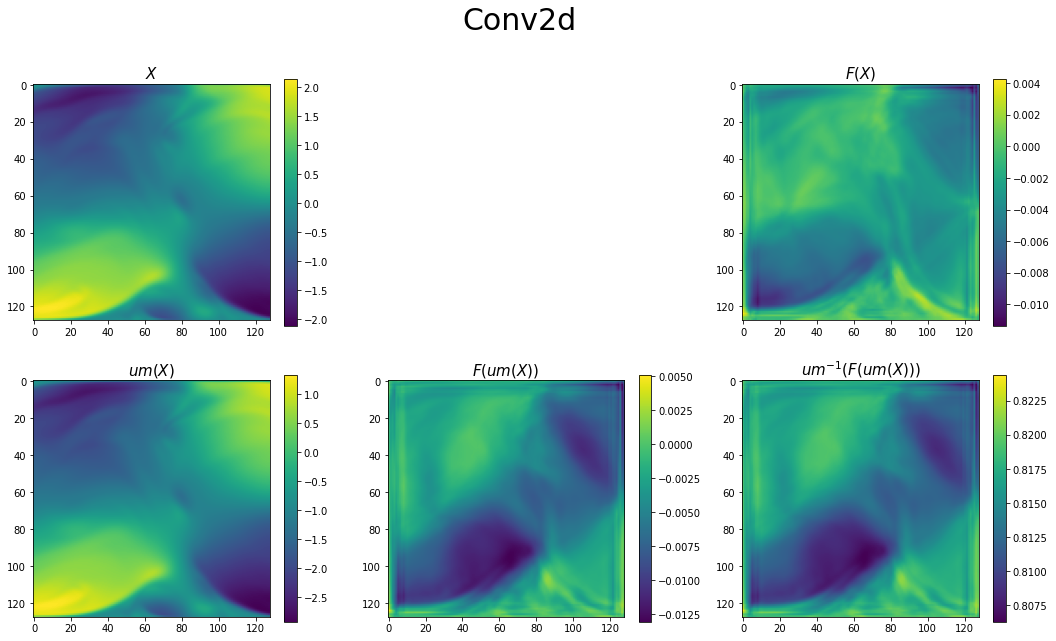

In [14]:
blur_xx = blur_input(xx.reshape(-1, 2, 2, 128, 128))
xx_out = model(blur_xx.to(device))
xx = xx.reshape(-1, 4, 128, 128)

um_xx = uniform_motion(xx.reshape(-1, 4, 128, 128), um_vector)

blur_um_xx = blur_input(um_xx.reshape(-1, 2, 2, 128, 128))
um_xx_out = model(blur_um_xx.to(device))

xx_out_um = uniform_motion((um_xx_out).cpu(), -um_vector)

direc = 0
fig=plt.figure(figsize=(18, 10))
plt.subplot(2, 3, 1)
plt.imshow(xx[0,direc].cpu().data.numpy())
plt.title(r"$X$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 3)
plt.imshow(xx_out[0,direc].cpu().data.numpy())
plt.title(r"$F(X)$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 4)
plt.imshow(um_xx[0, direc].cpu().data.numpy())
plt.title(r"$um(X)$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 5)
plt.imshow(um_xx_out[0,direc].cpu().data.numpy())
plt.title(r"$F(um(X))$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 6)
plt.imshow(xx_out_um[0, direc].cpu().data.numpy())
plt.title(r"$um^{-1}(F(um(X)))$", size = 15)
plt.colorbar()

plt.suptitle("Conv2d", size = 30)

plt.show()
fig.savefig(img_direc + '/rot_um_conv2d_um', bbox_inches='tight')

In [15]:
def rmse(y, y_hat):
    """Compute root mean squared error"""
    return torch.sqrt(torch.mean((y - y_hat).pow(2)))

def mse(y, y_hat):
    """Compute root mean squared error"""
    return torch.mean((y - y_hat).pow(2))

xx_out_sample = xx_out[0,direc].cpu()
xx_out_um_sample = xx_out_um[0, direc].cpu()
print(rmse(xx_out_sample, xx_out_um_sample))
print(mse(xx_out_sample, xx_out_um_sample))

tensor(0.8171, grad_fn=<SqrtBackward>)
tensor(0.6677, grad_fn=<MeanBackward0>)


In [ ]:
plt.hist(xx_out_rot[direc].cpu().data.numpy().flatten())

In [ ]:
plt.hist(xx_out[0,direc].cpu().data.numpy().flatten())

## Scale symmetric test

In [34]:
# scale ================================================================================
def scale(img, factor):
    scale_img = F.interpolate(img.unsqueeze(0), scale_factor = (1, factor, factor), mode="trilinear", align_corners = True).squeeze(0)
    return scale_img*(img.max() - img.min())/(scale_img.max() - scale_img.min())/factor

def pad_after_scale(scale_im, target_dim=128):
    dim_diff = target_dim - scale_im.shape[-1]
    padding_left = padding_top = dim_diff // 2
    padding_right = padding_bottom = dim_diff - dim_diff // 2
    paddings = (padding_left,padding_right, padding_top, padding_bottom)
    return F.pad(scale_im, paddings, 'constant', 0)

In [35]:
train_direc = "/global/cscratch1/sd/roseyu/Eliza/TF-net/Data/data_128/sample_"
input_length = 2
output_length = 3
batch_size = 4
train_indices = list(range(0, 1))
train_set = Dataset(train_indices, input_length, 40, output_length, train_direc)
train_loader = data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
for xx, yy in train_loader:
    break  

In [42]:
torch.manual_seed(10)
factor = 0.5

# model = Ani_layer(input_channels = 1, output_channels = 1, kernel_size = 7).to(device)
model = rot_um_scale_cnn(input_channels = input_length*2, output_channels = 1, hidden_dim = 128, num_layers = 4, kernel_size = 7, activation = "tanh").to(device)

In [51]:
test = torch.rand((1, 2, 128, 128))
print(test.shape)
test[:,:,32:-32,32:-32].shape

torch.Size([1, 2, 128, 128])


torch.Size([1, 2, 64, 64])

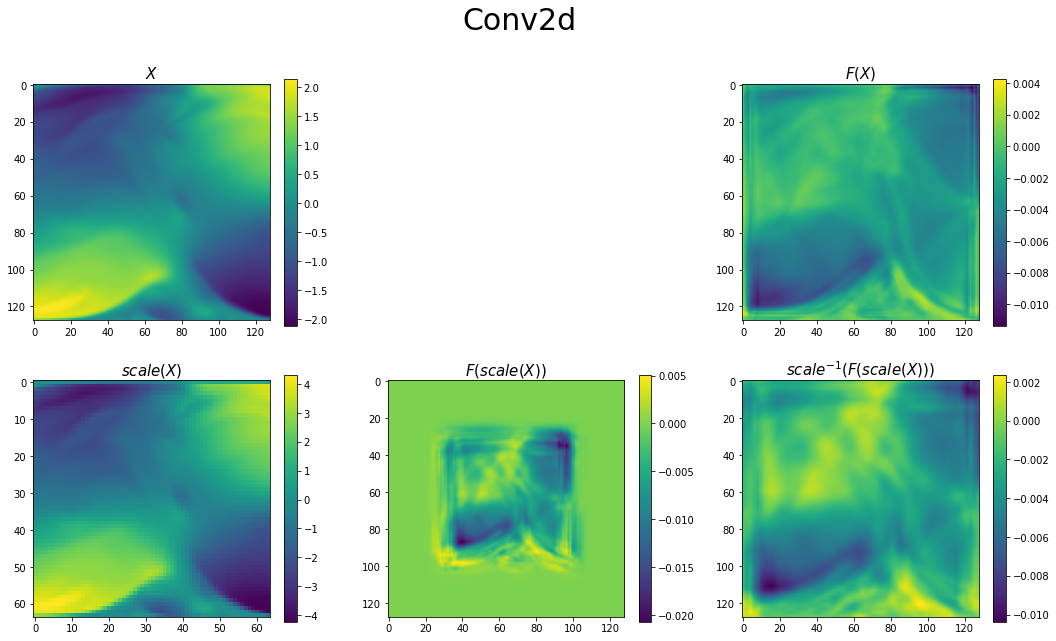

In [52]:
blur_xx = blur_input(xx.reshape(-1, 2, 2, 128, 128))
xx_out = model(blur_xx.to(device))
xx = xx.reshape(-1, 4, 128, 128)

scale_xx = scale(xx, factor)
padded_scale_img = pad_after_scale(scale_xx)

blur_scale_xx = blur_input(padded_scale_img.reshape(-1, 2, 2, 128, 128))
scale_xx_out = model(blur_scale_xx.to(device))
xx_out_scale = scale((scale_xx_out[:,:,32:-32,32:-32]).cpu(), 1/factor)

direc = 0
fig=plt.figure(figsize=(18, 10))
plt.subplot(2, 3, 1)
plt.imshow(xx[0,direc].cpu().data.numpy())
plt.title(r"$X$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 3)
plt.imshow(xx_out[0,direc].cpu().data.numpy())
plt.title(r"$F(X)$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 4)
plt.imshow(scale_xx[0, direc].cpu().data.numpy())
plt.title(r"$scale(X)$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 5)
plt.imshow(scale_xx_out[0,direc].cpu().data.numpy())
plt.title(r"$F(scale(X))$", size = 15)
plt.colorbar()

plt.subplot(2, 3, 6)
plt.imshow(xx_out_scale[0, direc].cpu().data.numpy())
plt.title(r"$scale^{-1}(F(scale(X)))$", size = 15)
plt.colorbar()

plt.suptitle("Conv2d", size = 30)

plt.show()
fig.savefig(img_direc + '/rot_um_scale_conv2d_scale', bbox_inches='tight')

In [53]:
def rmse(y, y_hat):
    """Compute root mean squared error"""
    return torch.sqrt(torch.mean((y[:y_hat.shape[0], :y_hat.shape[1]] - y_hat).pow(2)))

def mse(y, y_hat):
    """Compute root mean squared error"""
    return torch.mean((y[:y_hat.shape[0], :y_hat.shape[1]] - y_hat).pow(2))

xx_out_sample = xx_out[0,direc].cpu()
xx_out_scale_sample = xx_out_scale[0, direc].cpu()
print(rmse(xx_out_sample, xx_out_scale_sample))
print(mse(xx_out_sample, xx_out_scale_sample))

tensor(0.0011, grad_fn=<SqrtBackward>)
tensor(1.2630e-06, grad_fn=<MeanBackward0>)


### Basic Matrices

In [ ]:
def rotMat(theta, inverse = False):
    theta = torch.tensor(theta)
    sin = torch.sin(theta)
    cos = torch.cos(theta)
    mat = torch.cat([cos.unsqueeze(1), sin.unsqueeze(1)*(-1), sin.unsqueeze(1), cos.unsqueeze(1)], dim = 1).reshape(-1,2,2) 
    if inverse:
        return mat.inverse().float()
    return mat.float()


max_radius = 16
min_radius = 0.5
step_radius = 0.25
num_radius = (max_radius - min_radius-1)/step_radius
center_x = max_radius-1
center_y = max_radius-1
basis = torch.zeros(int(num_radius), 4, 31, 31, 2, 2)

Ms = [torch.tensor([[1.,0.],[0.,0.]]), torch.tensor([[0.,1.],[0.,0.]]), torch.tensor([[0.,0.],[1.,0.]]), torch.tensor([[0.,0.],[0.,1.]])]
for rad_id in range(1, int(num_radius)):
    rad = (rad_id-1) * step_radius + min_radius 
    for i in range(len(Ms)):
        for rr in np.linspace(rad - 0.25, rad + 0.25, 6):
            theta = np.linspace(0, np.pi*2, int(500*rr//2))
            x = (np.round(np.cos(theta)*rad)).astype("int32") 
            y = (np.round(np.sin(theta)*rad)).astype("int32")
            id_x = center_x - y 
            id_y = center_y + x
            out = torch.einsum("zac, zcd -> zad", (torch.einsum("zab, bc->zac", (rotMat(theta), Ms[i])), rotMat(theta, inverse = True)))
            for j in range(len(x)):
                basis[rad_id, i, id_x[j], id_y[j]] += out[j] 
                
for i in range(len(Ms)):
    basis[0, i, center_x, center_y] = 500*Ms[i]

In [ ]:
basis.shape

In [ ]:
plt.imshow(basis[1,0,:,:,0,0])

In [ ]:
basis[1,3,15,15]

In [ ]:
basis[1,0,15,15]

In [ ]:
torch.save(basis/500, "kernel_basis.pt")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X, Y = np.meshgrid(np.arange(-1, 2, 1), np.arange(1, -2, -1))

x_shape = X.shape

U = basis[0,0,:,:,0,0]
V = basis[0,0,:,:,1,0]

U2 = basis[0,0,:,:,0,1]
V2 = basis[0,0,:,:,1,1]

fig, ax = plt.subplots()
q = ax.quiver(X, Y, U, V, units='xy' ,scale=2, color='green')
q = ax.quiver(X, Y, U2, V2, units='xy' ,scale=2, color='red')
ax.set_aspect('equal')

plt.xlim(-2,2)
plt.ylim(-2,2)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X, Y = np.meshgrid(np.arange(-1, 2, 1), np.arange(1, -2, -1))

x_shape = X.shape

U = basis[0,0,:,:,0,1]
V = basis[0,0,:,:,1,1]

def rotate_vec(img, degree):
    #img shape 2*128*128
    img = torch.tensor(img).float()
    #2*2 2*1*128*128 -> 2*1*128*128
    
    theta = torch.tensor(degree/180*np.pi)
    rot_m = torch.tensor([[torch.cos(theta), -torch.sin(theta)], [torch.sin(theta), torch.cos(theta)]])
    img = torch.einsum("ab, bcde -> acde",(rot_m, img.unsqueeze(1))).squeeze(1)
    return img

stack = np.stack([U,V])
rot_U = rotate_vec(stack, 90)[0]
rot_V = rotate_vec(stack, 90)[1]


fig, ax = plt.subplots()
q = ax.quiver(X, Y, U, V, units='xy' ,scale=2, color='red')

ax.set_aspect('equal')

plt.xlim(-2,2)
plt.ylim(-2,2)

In [ ]:
torch.save(basis, "kernel_basis.pt")
print("Basic Matrices Saved")

In [ ]:
basis = torch.load("kernel_basis.pt")
basis = torch.sum(basis, dim = 0).data.numpy()
plt.imshow(basis[0,:,:,0,1])
plt.colorbar()

In [ ]:
def rotMat(theta, inverse = False):
    theta = torch.tensor(theta)
    sin = torch.sin(theta)
    cos = torch.cos(theta)
    mat = torch.cat([cos.unsqueeze(1), sin.unsqueeze(1)*(-1), sin.unsqueeze(1), cos.unsqueeze(1)], dim = 1).reshape(-1,2,2) 
    if inverse:
        return mat.inverse().float()
    return mat.float()

basis = torch.zeros(2, 4, 3, 3, 2, 2)
Ms = [torch.tensor([[1.,0.],[0.,0.]]), torch.tensor([[0.,1.],[0.,0.]]), torch.tensor([[0.,0.],[1.,0.]]), torch.tensor([[0.,0.],[0.,1.]])]
for rad in range(1, 2):
    for i in range(len(Ms)):
        for rr in np.linspace(rad - 0.25, rad + 0.25, 6):
            theta = np.linspace(0, np.pi*2, int(500*rr//2))
            x = (np.round(np.cos(theta)*rad)).astype("int32") + 1
            y = (np.round(np.sin(theta)*rad)).astype("int32") + 1
            out = torch.einsum("zac, zcd -> zad", (torch.einsum("zab, bc->zac", (rotMat(theta), Ms[i])), rotMat(theta, inverse = True)))
            for j in range(len(x)):
                basis[rad-1, i, x[j], y[j]] += out[j]     


In [ ]:
def rotate(img, degree):
    #img shape 2*128*128
    #2*2 2*1*128*128 -> 2*1*128*128
    theta = torch.tensor(degree/180*np.pi)
    rot_m = torch.tensor([[torch.cos(theta), -torch.sin(theta)], [torch.sin(theta), torch.cos(theta)]])
    img = torch.einsum("ab, bcde -> acde",(rot_m, img.unsqueeze(1))).squeeze(1)
    mmin = torch.min(img)
    mmax = torch.max(img)
    img = normalize(img).data.numpy()
    x = TTen(TF.rotate(Image.fromarray(np.uint8(img[0]*255)),degree, expand =  True))
    y = TTen(TF.rotate(Image.fromarray(np.uint8(img[1]*255)),degree, expand =  True))
    rot_img = torch.cat([x, y], dim = 0)
    rot_img[rot_img!=0] = normalize(rot_img[rot_img!=0])
    rot_img[rot_img!=0] = rot_img[rot_img!=0]*(mmax - mmin) + mmin
    return rot_img

def rotate_img(img, degree):
    img = torch.tensor(img).float()
    mmin = torch.min(img)
    mmax = torch.max(img)
    img = normalize(img).data.numpy()
    x = TTen(TF.rotate(Image.fromarray(np.uint8(img[0]*255)),degree,expand =  True))
    y = TTen(TF.rotate(Image.fromarray(np.uint8(img[1]*255)),degree,expand =  True))
    rot_img = torch.cat([x, y], dim = 0)
    #print(np.max(img), np.min(img), torch.max(rot_img), torch.min(rot_img))
    rot_img = rot_img*(mmax - mmin) + mmin
    return rot_img.cpu().data.numpy()

def rotate_vec(img, degree):
    #img shape 2*128*128
    img = torch.tensor(img).float()
    #2*2 2*1*128*128 -> 2*1*128*128
    
    theta = torch.tensor(degree/180*np.pi)
    rot_m = torch.tensor([[torch.cos(theta), -torch.sin(theta)], [torch.sin(theta), torch.cos(theta)]])
    img = torch.einsum("ab, bcde -> acde",(rot_m, img.unsqueeze(1))).squeeze(1)
    return img

import matplotlib.pyplot as plt
import numpy as np

X, Y = np.meshgrid(np.arange(-1, 2, 1), np.arange(1, -2, -1))

x_shape = X.shape

U = np.ones(x_shape)
V = np.zeros(x_shape)

#for i in range(x_shape[0]):
 #   for j in range(x_shape[1]):
       # U[i,j] = 1-i/10
        #V[i,j] = np.sin(i/20*7)

U[2,2] = 0
V[2,2] = 1


stack = np.stack([U,V])
rot_U = rotate_vec(stack, 90)[0]
rot_V = rotate_vec(stack, 90)[1]


fig, ax = plt.subplots()
q = ax.quiver(X, Y, U, V, units='xy' ,scale=2, color='red')

ax.set_aspect('equal')

plt.xlim(-2,2)
plt.ylim(-2,2)


fig, ax = plt.subplots()
q = ax.quiver(X, Y, rot_U, rot_V, units='xy' ,scale=2, color='red')
ax.set_aspect('equal')

plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()

stack = np.stack([rot_U,rot_V])
rot_U2 = rotate_img(stack, 90)[0]
rot_V2 = rotate_img(stack, 90)[1]
fig, ax = plt.subplots()
q = ax.quiver(X, Y, rot_U2, rot_V2, units='xy' ,scale=2, color='red')
ax.set_aspect('equal')

plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_channels, output_channels, hidden_dim,  kernel_size, num_layers, activation = False, bias = True):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(input_channels*2, hidden_dim, kernel_size = kernel_size, padding = (kernel_size-1)//2, bias = bias),
            #nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size = kernel_size, padding = (kernel_size-1)//2, bias = bias),
            #nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size = kernel_size, padding = (kernel_size-1)//2, bias = bias),
            #nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size = kernel_size, padding = (kernel_size-1)//2, bias = bias),
            #nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, output_channels*2, kernel_size = kernel_size, padding = (kernel_size-1)//2, bias = bias)
        )
        self.initial_params = self.layer[0].weight.clone()
         
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                
    def forward(self, xx):
        xx = xx.reshape(xx.shape[0], -1, xx.shape[-2], xx.shape[-1])
        out = self.layer(xx)
        out = out.reshape(out.shape[0], out.shape[1]//2, 2, xx.shape[-2], xx.shape[-1])
        return out